In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

SEED = 999
print("Random Seed: ", SEED)
random.seed(SEED)
torch.manual_seed(SEED)

Random Seed:  999


In [2]:
DATA_PATH = "CelebA"    # data path
WORKERS = 2    # dataloader
BATCH_SIZE = 128    # batch size
IMG_SIZE = 64    # image size
NC = 3    # channels
NZ = 100    # Size of z latent vector (i.e. size of generator input)
NGF = 64    # Size of feature maps in generator
NDF = 64    # Size of feature maps in discriminator
EPOCHS = 5    # epochs
LR = 0.0002    # learning rate
BETA1 = 0.5    # Beta1 hyperparam for Adam optimizers
GPU = 1    # using GPU

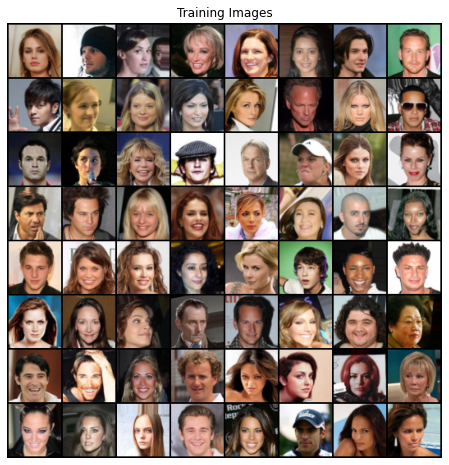

In [8]:
dataset = dset.ImageFolder(root=DATA_PATH,
                          transform=transforms.Compose([
                              transforms.Resize(IMG_SIZE),
                              transforms.CenterCrop(IMG_SIZE),
                              transforms.ToTensor(),
                              # rgb mean / rgb standard deviation
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                          ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS)

device = torch.device("cuda:0" if (torch.cuda.is_available() and GPU) else "cpu")

real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2,
                                         normalize=True).cpu(), (1,2,0)))

In [9]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# From the DCGAN paper, the authors specify that all model weights shall be randomly initialized
# from a Normal distribution with mean=0, stdev=0.02. 

In [18]:
# Generator
class Generator(nn.Module):
    def __init__(self, GPU):
        super(Generator, self).__init__()
        self.GPU = GPU
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            # inC, outC, k, s, p
            nn.ConvTranspose2d( NZ, NGF * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(NGF * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(NGF * 8, NGF * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NGF * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( NGF * 4, NGF * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NGF * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( NGF * 2, NGF, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NGF),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( NGF, NC, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )
    def forward(self, x):
        return self.main(x)

In [19]:
# create generator
netG = Generator(GPU).to(device)
if (device.type == 'cuda') and GPU:
    netG = nn.DataParallel(netG, list(range(GPU)))
netG.apply(weights_init)
print(netG)

DataParallel(
  (module): Generator(
    (main): Sequential(
      (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
      (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU(inplace=True)
      (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2